In [28]:
!python --version

Python 3.10.12


In [1]:
import os
import math
import string
import random
import time
import subprocess
import sys
# import wandb
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    import easyocr
except ImportError:
    print("easyocr module not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "easyocr"])
    import easyocr

try:
    import editdistance
except ImportError:
    print("editdistance module not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "editdistance"])
    import editdistance

try:
    import keras_ocr
except ImportError:
    !pip install keras-ocr -q
    import keras_ocr

reader = easyocr.Reader(['ru'])

easyocr module not found. Installing now...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 690.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.1 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [2]:
# !gdown 1SznyDq4Hddcy7PGoPQGsycSpNjXv8a_U # /content/craft_mlt_25k.pth
!gdown 1_NgWNm7R9xfkKqWYqo35j5rbUAURvm3P # /content/ocr_transformer_rn50_64x256_53str_jit.pt
!gdown 1fOCrZsjiXtX8N_Yeb_PK6lcyDGcTJQoB # /content/Cyrillic Handwriting Dataset.zip
!gdown 1v0PqxCfPWn2HMd-ZgyYm7HlgNQKXQgEM # /content/rukopi3.png

Downloading...
From (original): https://drive.google.com/uc?id=1_NgWNm7R9xfkKqWYqo35j5rbUAURvm3P
From (redirected): https://drive.google.com/uc?id=1_NgWNm7R9xfkKqWYqo35j5rbUAURvm3P&confirm=t&uuid=83304ef0-94cc-4dc1-a4d7-cfe23bc548ba
To: /content/ocr_transformer_rn50_64x256_53str_jit.pt
100% 176M/176M [00:01<00:00, 102MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fOCrZsjiXtX8N_Yeb_PK6lcyDGcTJQoB
From (redirected): https://drive.google.com/uc?id=1fOCrZsjiXtX8N_Yeb_PK6lcyDGcTJQoB&confirm=t&uuid=1bb55346-9c61-4e40-9270-33a348239499
To: /content/Cyrillic Handwriting Dataset.zip
100% 1.62G/1.62G [00:19<00:00, 81.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v0PqxCfPWn2HMd-ZgyYm7HlgNQKXQgEM
To: /content/rukopi3.png
100% 43.9k/43.9k [00:00<00:00, 74.0MB/s]


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/Cyrillic Handwriting Dataset.zip", 'r')
zip_ref.extractall("/content/Cyrillic Handwriting Dataset")
zip_ref.close()

In [4]:
!ls "/content/Cyrillic Handwriting Dataset"

test  test.tsv	train  train.tsv


## CONFIG

In [5]:
class Hparams():
    def __init__(self):

        # SETS OF CHARACTERS
        self.cyrillic = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'EOS']
        # CHARS TO REMOVE
        self.del_sym = []

        self.lr = 0.01
        self.batch_size = 1
        self.hidden = 512
        self.enc_layers = 2
        self.dec_layers = 2
        self.nhead = 4
        self.dropout = 0.0

        # IMAGE SIZE
        self.width = 256
        self.height = 64

WANDB_LOG = False

PATH_TEST_DIR = '/content/Cyrillic Handwriting Dataset/test/'
PATH_TEST_LABELS = '/content/Cyrillic Handwriting Dataset/test.tsv'
PATH_TRAIN_DIR = '/content/Cyrillic Handwriting Dataset/train/'
PATH_TRAIN_LABELS = '/content/Cyrillic Handwriting Dataset/train.tsv'

torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hp = Hparams()

# CREATE MAPS FROM CHARACTERS TO INDICIES AND VISA VERSA
char2idx = {char: idx for idx, char in enumerate(hp.cyrillic)}
idx2char = {idx: char for idx, char in enumerate(hp.cyrillic)}

## UTILITY FUNCTIONS

In [6]:
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# text to array of indicies
def text_to_labels(s, char2idx):
    return [char2idx['SOS']] + [char2idx[i] for i in s if i in char2idx.keys()] + [char2idx['EOS']]

# convert images and labels into defined data structures
def process_data(image_dir, labels_dir, ignore=[]):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            print('ValueError:', x)
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels

# MAKE TEXT TO BE THE SAME LENGTH
class TextCollate():
    def __call__(self, batch):
        x_padded = []
        max_y_len = max([i[1].size(0) for i in batch])
        y_padded = torch.LongTensor(max_y_len, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[:y.size(0), i] = y

        x_padded = torch.cat(x_padded)
        return x_padded, y_padded


# TRANSLATE INDICIES TO TEXT
def labels_to_text(s, idx2char):
    """
    params
    ---
    idx2char : dict
        keys : int
            indicies of characters
        values : str
            characters
    returns
    ---
    S : str
    """
    S = "".join([idx2char[i] for i in s])
    if S.find('EOS') == -1:
        return S
    else:
        return S[:S.find('EOS')]


# COMPUTE CHARACTER ERROR RATE
def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


# RESIZE AND NORMALIZE IMAGE
def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = hp.height
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = hp.width
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img

# GENERATE IMAGES FROM FOLDER
def generate_data(img_paths):
    """
    params
    ---
    names : list of str
        paths to images
    returns
    ---
    data_images : list of np.array
        images in np.array format
    """
    data_images = []
    for path in tqdm(img_paths):
        # Ensure path is a string
        if not isinstance(path, str):
            path = str(path)
        img = cv2.imread(path)
        try:
            img = process_image(img)
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            continue
        data_images.append(img)
    return data_images

def train(model, optimizer, criterion, iterator):
    """
    params
    ---
    model : nn.Module
    optimizer : nn.Object
    criterion : nn.Object
    iterator : torch.utils.data.DataLoader
    returns
    ---
    epoch_loss / len(iterator) : float
        overall loss
    """
    model.train()
    epoch_loss = 0
    counter = 0
    for src, trg in iterator:
        counter += 1
        if counter % 500 == 0:
            print('[', counter, '/', len(iterator), ']')
        if torch.cuda.is_available():
            src, trg = src.cuda(), trg.cuda()

        optimizer.zero_grad()
        output = model(src, trg[:-1, :])

        loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# GENERAL FUNCTION FROM TRAINING AND VALIDATION
def train_all(model,optimizer,criterion,scheduler, train_loader, val_loader,epoch_limit):
    train_loss = 0
    confuse_dict = dict()
    for epoch in range(0, epoch_limit):
        start_time = time.time()
        print(f'Epoch: {epoch + 1:02}')
        print("-----------train------------")
        train_loss = train(model, optimizer, criterion, train_loader)
        print("train loss :",train_loss)
        print("\n-----------valid------------")
        valid_loss = evaluate(model, criterion, val_loader)
        print("validation loss :",valid_loss)
        print("-----------eval------------")
        eval_loss_cer, eval_accuracy = validate(model, val_loader)
        scheduler.step(eval_loss_cer)

        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        print(f"Time taken for epoch: {elapsed_mins}m {elapsed_secs}s")

        if WANDB_LOG and epoch%4 == 0:
            wandb.log({'Train loss WER': train_loss, "Validation loss WER": valid_loss, 'Validation Word Accuracy': 100 - eval_accuracy,
                       'Validation loss CER': eval_loss_cer,'Learning Rate':scheduler._last_lr[0]})



def validate(model, dataloader):
    """
    params
    ---
    model : nn.Module
    dataloader :
    returns
    ---
    cer_overall / len(dataloader) * 100 : float
    wer_overall / len(dataloader) * 100 : float
    """
    idx2char = dataloader.dataset.idx2char
    char2idx = dataloader.dataset.char2idx
    model.eval()
    show_count = 0
    wer_overall = 0
    cer_overall = 0
    with torch.no_grad():
        for (src, trg) in dataloader:
            img = np.moveaxis(src[0].numpy(), 0, 2)
            if torch.cuda.is_available():
              src = src.cuda()

            out_indexes = [char2idx['SOS'], ]

            for i in range(100):

                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)

                #output = model.fc_out(model.transformer.decoder(model.pos_decoder(model.decoder(trg_tensor)), memory))
                output = model(src,trg_tensor)
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == char2idx['EOS']:
                    break

            out_char = labels_to_text(out_indexes[1:], idx2char)
            real_char = labels_to_text(trg[1:, 0].numpy(), idx2char)
            wer_overall += int(real_char != out_char)
            if out_char:
                cer = char_error_rate(real_char, out_char)
            else:
                cer = 1

            cer_overall += cer
            if WANDB_LOG and out_char != real_char:
                wandb.log({'Validation Character Accuracy': (1-cer)*100})
                wandb.log({"Validation Examples": wandb.Image(img, caption="Pred: {} Truth: {}".format(out_char, real_char))})
                show_count += 1

    return cer_overall / len(dataloader) * 100, wer_overall / len(dataloader) * 100


# SPLIT DATASET INTO TRAIN AND VALID PARTS
def train_valid_split(img2label, train_part=0.9, val_part=0.1):
    """
    Split dataset into train and valid parts.

    Args:
        img2label (dict): Keys are paths to images, values are labels (transcripts of crops).
        train_part (float, optional): Training part. Defaults to 0.1.
        val_part (float, optional): Validation part. Defaults to 0.3.

    Returns:
        imgs_val (list of str): Paths for validation.
        labels_val (list of str): Labels for validation.
        imgs_train (list of str): Paths for training.
        labels_train (list of str): Labels for training.
    """
    # Check if train_part and val_part sum to more than 1.0
    if train_part + val_part > 1.0:
        print("Error: train_part and val_part sum to more than 1.0")
        return None, None, None, None

    imgs_val, labels_val = [], []
    imgs_train, labels_train = [], []

    N_train = int(len(img2label) * train_part)
    N_val = int(len(img2label) * val_part)
    items = list(img2label.items())
    random.shuffle(items)
    for i, item in enumerate(items):
        if i < N_train:
            imgs_train.append(item[0])
            labels_train.append(item[1])
        elif i < N_train + N_val:
            imgs_val.append(item[0])
            labels_val.append(item[1])
        else:
            break  # Ignore the rest of the utils

    print('train part:{}'.format(len(imgs_train)))
    print('valid part:{}'.format(len(imgs_val)))
    return imgs_val, labels_val, imgs_train, labels_train


def evaluate(model, criterion, iterator):
    """
    params
    ---
    model : nn.Module
    criterion : nn.Object
    iterator : torch.utils.data.DataLoader
    returns
    ---
    epoch_loss / len(iterator) : float
        overall loss
    """
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for (src, trg) in tqdm(iterator):
            src, trg = src.cuda(), trg.cuda()
            output = model(src, trg[:-1, :])
            loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# PREPARE DATASET FROM TRAINING
# IT CREATES MIXED DATASET: THE FIRST PART COMES FROM REAL DATA AND THE SECOND PART COMES FORM GENERATOR
def get_mixed_data(pretrain_image_dir, pretrain_labels_dir, train_image_dir, train_labels_dir, pretrain_part=0.0):
    img2label1, chars1, all_words1 = process_data(pretrain_image_dir, pretrain_labels_dir)  # PRETRAIN PART
    img2label2, chars2, all_words2 = process_data(train_image_dir, train_labels_dir)  # TRAIN PART
    img2label1_list = list(img2label1.items())
    N = len(img2label1_list)
    for i in range(N):
        j = np.random.randint(0, N)
        item = img2label1_list[j]
        img2label2[item[0]] = item[1]
    return img2label2

# MAKE PREDICTION
def prediction(model, test_dir, char2idx, idx2char):
    """
    params
    ---
    model : nn.Module
    test_dir : str
        path to directory with images
    char2idx : dict
        map from chars to indicies
    id2char : dict
        map from indicies to chars
    returns
    ---
    preds : dict
        key : name of image in directory
        value : dict with keys ['p_value', 'predicted_label']
    """
    preds = {}
    os.makedirs('/output', exist_ok=True)
    model.eval()

    with torch.no_grad():
        for filename in os.listdir(test_dir):
            img = cv2.imread(test_dir + filename)
            img = process_image(img).astype('uint8')
            img = img / img.max()
            img = np.transpose(img, (2, 0, 1))
            src = torch.FloatTensor(img).unsqueeze(0).to(device)
            p_values = 1
            out_indexes = [char2idx['SOS'], ]

            for i in range(100):

                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)

                output = model(src,trg_tensor)
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == char2idx['EOS']:
                    break

            pred = labels_to_text(out_indexes[1:], idx2char)
            preds[filename] = {'predicted_label': pred, 'p_values': p_values}

    return preds

## TRANSFORMER MODEL

In [7]:
from torchvision import models

class TransformerModel(nn.Module):
    def __init__(self, bb_name, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1, pretrained=False):
        # здесь загружаем сверточную модель, например, resnet50
        super(TransformerModel, self).__init__()
        self.backbone = models.__getattribute__(bb_name)(pretrained=pretrained)
        self.backbone.fc = nn.Conv2d(2048, int(hidden/2), 1)

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout,
                                          activation='relu')

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

        print('backbone: {}'.format(bb_name))
        print('layers: {}'.format(enc_layers))
        print('heads: {}'.format(nhead))
        print('dropout: {}'.format(dropout))
        print(f'{count_parameters(self):,} trainable parameters')

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)
        x = self.backbone.conv1(src)

        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x) # [64, 2048, 2, 8] : [B,C,H,W]

        x = self.backbone.fc(x) # [64, 256, 2, 8] : [B,C,H,W]
        x = x.permute(0, 3, 1, 2) # [64, 8, 256, 2] : [B,W,C,H]
        x = x.flatten(2) # [64, 8, 512] : [B,W,CH]
        x = x.permute(1, 0, 2) # [8, 64, 512] : [W,B,CH]

        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x) # [8, 64, 512]
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask) # [13, 64, 512] : [L,B,CH]
        output = self.fc_out(output) # [13, 64, 92] : [L,B,H]

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

## DATASET CLASS

In [8]:
# store list of images' names (in directory) and does some operations with images
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, images_name, labels, char2idx, idx2char, eval=False):
        """
        params
        ---
        images_name : list
            list of names of images (paths to images)
        labels : list
            list of labels to correspondent images from images_name list
        char2idx : dict
        idx2char : dict
        """
        self.images_name = images_name
        self.labels = labels
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.eval = eval
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            p.torch_transform(),  # random distortion and shear
            #transforms.Resize((int(hp.height *1.05), int(hp.width *1.05))),
            #transforms.RandomCrop((hp.height, hp.width)),
            transforms.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
            transforms.RandomRotation(degrees=(-9, 9), fill=255),
            transforms.RandomAffine(10 ,None ,[0.6 ,1] ,3 ), # ,fillcolor=255
            transforms.ToTensor()
        ])

    def _transform(self, X):
        j = np.random.randint(0, 3, 1)[0]
        if j == 0:
            return self.transform(X)
        if j == 1:
            return tt(ld(vignet(X)))
        if j == 2:
            return tt(ld(un(X)))


    def __getitem__(self, index):
        img = self.images_name[index]
        if not self.eval:
            img = self.transform(img)
            img = img / img.max()
            img = img ** (random.random() * 0.7 + 0.6)
        else:
            img = np.transpose(img, (2, 0, 1))
            img = img / img.max()

        label = text_to_labels(self.labels[index], self.char2idx)
        return (torch.FloatTensor(img), torch.LongTensor(label))

    def __len__(self):
        return len(self.labels)

## AUGMENTATIONS

In [9]:
!pip install Augmentor
import Augmentor
from torchvision import transforms
import numpy as np
import cv2


class Vignetting(object):
    def __init__(self,
                 ratio_min_dist=0.2,
                 range_vignette=(0.2, 0.8),
                 random_sign=False):
        self.ratio_min_dist = ratio_min_dist
        self.range_vignette = np.array(range_vignette)
        self.random_sign = random_sign

    def __call__(self, X, Y=None):
        h, w = X.shape[:2]
        min_dist = np.array([h, w]) / 2 * np.random.random() * self.ratio_min_dist

        # create matrix of distance from the center on the two axis
        x, y = np.meshgrid(np.linspace(-w / 2, w / 2, w), np.linspace(-h / 2, h / 2, h))
        x, y = np.abs(x), np.abs(y)

        # create the vignette mask on the two axis
        x = (x - min_dist[0]) / (np.max(x) - min_dist[0])
        x = np.clip(x, 0, 1)
        y = (y - min_dist[1]) / (np.max(y) - min_dist[1])
        y = np.clip(y, 0, 1)

        # then get a random intensity of the vignette
        vignette = (x + y) / 2 * np.random.uniform(*self.range_vignette)
        vignette = np.tile(vignette[..., None], [1, 1, 3])

        sign = 2 * (np.random.random() < 0.5) * (self.random_sign) - 1
        X = X * (1 + sign * vignette)
        return X


class LensDistortion(object):
    def __init__(self, d_coef=(0.15, 0.05, 0.1, 0.1, 0.05)):
        self.d_coef = np.array(d_coef)

    def __call__(self, X):
        # get the height and the width of the image
        h, w = X.shape[:2]

        # compute its diagonal
        f = (h ** 2 + w ** 2) ** 0.5

        # set the image projective to carrtesian dimension
        K = np.array([[f, 0, w / 2],
                      [0, f, h / 2],
                      [0, 0, 1]])

        d_coef = self.d_coef * np.random.random(5)  # value
        d_coef = d_coef * (2 * (np.random.random(5) < 0.5) - 1)  # sign
        # Generate new camera matrix from parameters
        M, _ = cv2.getOptimalNewCameraMatrix(K, d_coef, (w, h), 0)

        # Generate look-up tables for remapping the camera image
        remap = cv2.initUndistortRectifyMap(K, d_coef, None, M, (w, h), 5)

        # Remap the original image to a new image
        X = cv2.remap(X, *remap, cv2.INTER_LINEAR)
        return X


class UniformNoise(object):
    def __init__(self, low=-50, high=50):
        self.low = low
        self.high = high

    def __call__(self, X):
        noise = np.random.uniform(self.low, self.high, X.shape)
        X = X + noise
        return X


vignet = Vignetting()
un = UniformNoise()
tt = transforms.ToTensor()
p = Augmentor.Pipeline()
ld = LensDistortion()
p.shear(max_shear_left=2, max_shear_right=2, probability=0.7)
p.random_distortion(probability=1.0, grid_width=3, grid_height=3, magnitude=11)

## INFERENCE

In [10]:
def inference(model, image_input, char2idx, idx2char):
    """
    params
    ---
    model : pytorch model
    image_path : str
        path to the image
    char2idx : dict
    idx2char : dict
    returns
    ---
    predicted_transcript : str
    """
    # Load and preprocess the image

    # Check if image_input is a numpy array
    if isinstance(image_input, np.ndarray):
        img = image_input
    else:
        # Load and preprocess the image
        img = cv2.imread(image_input)

    img = process_image(img).astype('uint8')
    img = img / img.max()
    img = np.transpose(img, (2, 0, 1))
    src = torch.FloatTensor(img).unsqueeze(0).to(device)

    # Make prediction
    p_values = 1
    out_indexes = [char2idx['SOS'], ]

    for i in range(100):
        trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
        output = model(src,trg_tensor)
        out_token = output.argmax(2)[-1].item()
        out_indexes.append(out_token)
        if out_token == char2idx['EOS']:
            break

    # Convert prediction to transcript
    predicted_transcript = labels_to_text(out_indexes[1:], idx2char)

    return predicted_transcript

In [11]:
model = TransformerModel('resnet50', len(hp.cyrillic), hidden=hp.hidden, enc_layers=hp.enc_layers, dec_layers=hp.dec_layers,
                         nhead=hp.nhead, dropout=hp.dropout).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/content/ocr_transformer_rn50_64x256_53str_jit.pt', map_location=device)['model'])

# model.load_state_dict(torch.load('/content/ocr_transformer_rn50_64x256_53str_jit.pt')['model'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


backbone: resnet50
layers: 2
heads: 4
dropout: 0.0
38,841,758 trainable parameters


<All keys matched successfully>

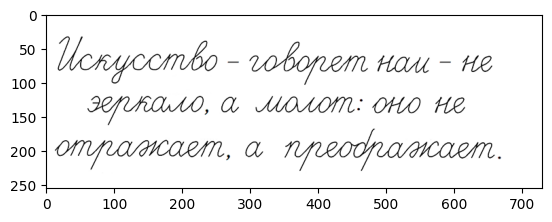

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO

image_path = "/content/rukopi3.png"

# img = Image.open(BytesIO(response.content))
img = Image.open(image_path)

# Save the image to a file
# image_path = "/content/downloaded_image.jpg"
# img.save(image_path)

# Convert the image to 'RGB' mode
img_rgb = img.convert('RGB')

# Save the image to a file
# image_path = "/content/downloaded_image.jpg"
img_rgb.save(image_path)

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.show()

In [13]:
detected_bboxes = reader.readtext(image_path)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [14]:
import pandas as pd

df = pd.DataFrame(detected_bboxes, columns=['bbox','text','conf'])
df['bbox'] = df['bbox'].apply(lambda bbox: [[int(coordinate) for coordinate in point] for point in bbox])
bboxes_series = df['bbox']
bboxes_series

0           [[6, 24], [266, 24], [266, 115], [6, 115]]
1         [[482, 54], [573, 54], [573, 93], [482, 93]]
2         [[610, 58], [662, 58], [662, 90], [610, 90]]
3       [[52, 106], [243, 106], [243, 166], [52, 166]]
4     [[254, 118], [290, 118], [290, 150], [254, 150]]
5     [[305, 111], [557, 111], [557, 151], [305, 151]]
6     [[570, 118], [622, 118], [622, 150], [570, 150]]
7         [[6, 174], [278, 174], [278, 228], [6, 228]]
8     [[290, 184], [326, 184], [326, 216], [290, 216]]
9     [[338, 156], [676, 156], [676, 243], [338, 243]]
10       [[298, 24], [488, 52], [474, 119], [284, 91]]
Name: bbox, dtype: object

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted transcript: Искусство
Predicted transcript: говорет
Predicted transcript: нак
Predicted transcript: не
Predicted transcript: малоты: оно
Predicted transcript: а
Predicted transcript: не
Predicted transcript: деркало.
Predicted transcript: преображает
Predicted transcript: а
Predicted transcript: отражает


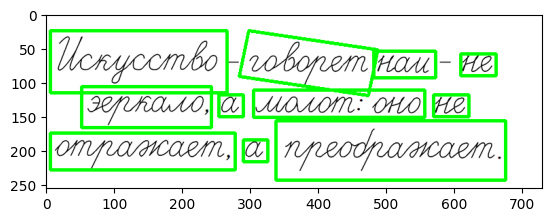

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def draw_bboxes(image, detected_bboxes, model, char2idx, idx2char):
    image_copy = image.copy()
    all_bboxes = []
    predicted_transcripts = []

    for detected_bbox in detected_bboxes:
        bbox, label, score = detected_bbox
        # Convert the bounding box to the format used by Keras OCR
        pts = [tuple(map(int, pt)) for pt in bbox]
        all_bboxes.append(pts)

        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(image_copy, [pts], True, (0,255,0), 3)

        x_min, y_min = np.min(pts, axis=0)[0]
        x_max, y_max = np.max(pts, axis=0)[0]
        extracted_image = image[y_min:y_max, x_min:x_max]

        predicted_transcript = inference(model, extracted_image, char2idx, idx2char)
        predicted_transcripts.append(predicted_transcript)

        print(f"Predicted transcript: {predicted_transcript}")

    return image_copy, all_bboxes, predicted_transcripts

def display_image(image):
    plt.imshow(image)
    plt.show()

# Usage
image_path = "/content/rukopi3.png"
image = load_image(image_path)
detected_bboxes.sort(key=lambda bbox: (np.mean([pt[1] for pt in bbox[0]]), np.mean([pt[0] for pt in bbox[0]])))
image_with_bboxes, all_bboxes, predicted_transcripts = draw_bboxes(image, detected_bboxes, model, char2idx, idx2char)
display_image(image_with_bboxes)

In [16]:
all_bboxes

[[(6, 24), (266, 24), (266, 115), (6, 115)],
 [(298, 24), (488, 52), (474, 119), (284, 91)],
 [(482, 54), (573, 54), (573, 93), (482, 93)],
 [(610, 58), (662, 58), (662, 90), (610, 90)],
 [(305, 111), (557, 111), (557, 151), (305, 151)],
 [(254, 118), (290, 118), (290, 150), (254, 150)],
 [(570, 118), (622, 118), (622, 150), (570, 150)],
 [(52, 106), (243, 106), (243, 166), (52, 166)],
 [(338, 156), (676, 156), (676, 243), (338, 243)],
 [(290, 184), (326, 184), (326, 216), (290, 216)],
 [(6, 174), (278, 174), (278, 228), (6, 228)]]

In [17]:
predicted_transcripts

['Искусство',
 'говорет',
 'нак',
 'не',
 'малоты: оно',
 'а',
 'не',
 'деркало.',
 'преображает',
 'а',
 'отражает']

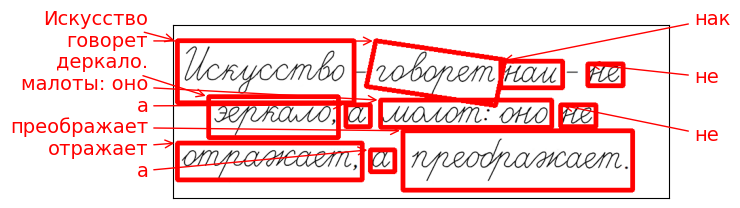

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras_ocr

def draw_annotations(image, bboxes, labels):
    # Convert bounding boxes to the correct format
    bboxes = [np.array(bbox).astype('float32') for bbox in bboxes]

    # Create a list of predictions where each prediction is a tuple of a word and its box
    predictions = list(zip(labels, bboxes))

    # Use Keras OCR's drawAnnotations function to draw the predictions
    fig = keras_ocr.tools.drawAnnotations(image=image, predictions=predictions)

    return fig

# Get your image
image_path = "/content/rukopi3.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Assuming 'bboxes' is your list of bounding boxes and 'labels' is your list of labels
fig = draw_annotations(image, all_bboxes, predicted_transcripts)

# Save the output figure to the current directory with the same name
output_dir = "./demo/output/"
os.makedirs(output_dir, exist_ok=True)

# Get the base name of the image path and add '_output' before the extension
base_name = os.path.basename(image_path)
name, ext = os.path.splitext(base_name)
output_name = f"{name}_output{ext}"

plt.savefig(os.path.join(output_dir, output_name), bbox_inches='tight', pad_inches=0)

# Display the annotated image
plt.show()

In [19]:
predicted_transcripts

['Искусство',
 'говорет',
 'нак',
 'не',
 'малоты: оно',
 'а',
 'не',
 'деркало.',
 'преображает',
 'а',
 'отражает']

In [20]:
predicted_transcripts

['Искусство',
 'говорет',
 'нак',
 'не',
 'малоты: оно',
 'а',
 'не',
 'деркало.',
 'преображает',
 'а',
 'отражает']

Check if weights for model already exist.

## TRAIN

I train on real data mixed with synthetic one to avoid forgetting data from the pretraining


source.txt and source_valid.txt are just the list of expressions used for generation. Expression are separated by '\n'.  

Change train_part=0.9, val_part=0.1 to train on whole data, will require ~18Gb Ram

In [21]:
img2label, _, all_words = process_data('/content/Cyrillic Handwriting Dataset/train/', '/content/Cyrillic Handwriting Dataset/train.tsv')

chars = hp.cyrillic

X_val, y_val, X_train, y_train = train_valid_split(img2label, train_part=0.01, val_part=0.001)

# TODO: use generators instead
X_train = generate_data(X_train)
X_val = generate_data(X_val)

train_dataset = TextLoader(X_train, y_train, char2idx ,idx2char, eval=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=hp.batch_size, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

val_dataset = TextLoader(X_val, y_val, char2idx,idx2char, eval=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False,
                                         batch_size=1, pin_memory=False,
                                         drop_last=False, collate_fn=TextCollate())


train part:722
valid part:72


100%|██████████| 72/72 [00:00<00:00, 516.41it/s]


<Figure size 1200x1200 with 0 Axes>

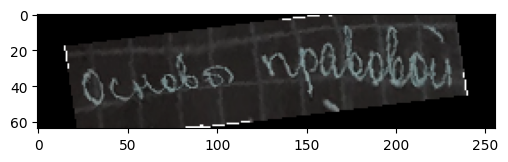

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=120)

examples = []
idx = 0

for batch in train_loader:
    img = batch[0]
    examples.append(img)
    idx += 1
    if idx == hp.batch_size:
        break
fig = plt.figure(figsize=(13, 13))
rows = int(hp.batch_size / 4) + 2
columns = int(hp.batch_size / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0].permute(2, 1, 0).permute(1, 0, 2))

trainig up to the decent metrics requires >10 hours; so, we advice you to train a model through several kaggle sessions or on your own GPU.

In [23]:
%timeit
model = TransformerModel('resnet50', len(hp.cyrillic), hidden=hp.hidden, enc_layers=hp.enc_layers, dec_layers=hp.dec_layers,
                         nhead=hp.nhead, dropout=hp.dropout).to(device)
optimizer = optim.SGD(model.parameters(), lr=hp.lr)
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

if WANDB_LOG:
    wandb.init(project="OCR-transformer", config={
        "learning_rate":hp.lr,
        "dropout": hp.dropout,
        "batch_size": hp.batch_size,
        "architecture": "RESNET50 + TRANSFORMER",
        "dataset": "64x512 train 29k",
        "classes": "92",
    })
    config = wandb.config

train_all(model, optimizer, criterion, scheduler,train_loader,val_loader, epoch_limit=2) # epoch_limit=160

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


backbone: resnet50
layers: 2
heads: 4
dropout: 0.0
38,841,758 trainable parameters
Epoch: 01
-----------train------------
[ 500 / 722 ]
train loss : 3.2386242370856437

-----------valid------------


100%|██████████| 72/72 [00:00<00:00, 80.88it/s]


validation loss : 2.9400646405087576
-----------eval------------
Time taken for epoch: 0m 46s
Epoch: 02
-----------train------------
[ 500 / 722 ]
train loss : 2.88448836697766

-----------valid------------


100%|██████████| 72/72 [00:00<00:00, 79.89it/s]


validation loss : 3.056617021560669
-----------eval------------
Time taken for epoch: 0m 44s


0.01 train_split takes ~1 min per epoch, 0.9 train_split would take ~90 mins

## TEST

In [24]:
def test(model, image_dir, label_dir, char2idx, idx2char, case=True, punct=False):
    """
    params
    ---
    model : pytorch model
    image_dir : str
        path to the folder with images
    label_dir : str
        path to the tsv file with labels
    char2idx : dict
    idx2char : dict
    case : bool
        if case is False then case of letter is ignored while comparing true and predicted transcript
    punct : bool
        if punct is False then punctution marks are ignored while comparing true and predicted transcript
    returns
    ---
    character_accuracy : float
    string_accuracy : float
    """
    img2label = dict()
    raw = open(label_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        x = t.split('\t')
        img2label[image_dir + x[0]] = x[1]
    preds = prediction(model, image_dir, char2idx, idx2char)
    N = len(preds)

    wer = 0
    cer = 0

    for item in preds.items():
        print(item)
        img_name = item[0]
        true_trans = img2label[image_dir + img_name]
        predicted_trans = item[1]

        if 'ё' in true_trans:
            true_trans = true_trans.replace('ё', 'е')
        if 'ё' in predicted_trans['predicted_label']:
            predicted_trans['predicted_label'] = predicted_trans['predicted_label'].replace('ё', 'е')

        if not case:
            true_trans = true_trans.lower()
            predicted_trans['predicted_label'] = predicted_trans['predicted_label'].lower()

        if not punct:
            true_trans = true_trans.translate(str.maketrans('', '', string.punctuation))
            predicted_trans['predicted_label'] = predicted_trans['predicted_label'].translate(str.maketrans('', '', string.punctuation))

        if true_trans != predicted_trans['predicted_label']:
            print('true:', true_trans)
            print('predicted:', predicted_trans)
            print('cer:', char_error_rate(predicted_trans['predicted_label'], true_trans))
            print('---')
            wer += 1
            cer += char_error_rate(predicted_trans['predicted_label'], true_trans)

    character_accuracy = 1 - cer / N
    string_accuracy = 1 - (wer / N)
    return character_accuracy, string_accuracy

In [25]:
model = TransformerModel('resnet50', len(hp.cyrillic), hidden=hp.hidden, enc_layers=hp.enc_layers, dec_layers=hp.dec_layers,
                         nhead=hp.nhead, dropout=hp.dropout).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/content/ocr_transformer_rn50_64x256_53str_jit.pt', map_location=device)['model'])

# model.load_state_dict(torch.load('/content/ocr_transformer_rn50_64x256_53str_jit.pt')['model'])

backbone: resnet50
layers: 2
heads: 4
dropout: 0.0
38,841,758 trainable parameters


<All keys matched successfully>

In [26]:
word_accur, char_accur = test(model,PATH_TEST_DIR,PATH_TEST_LABELS,char2idx,idx2char,case=False,punct=False)

('test238.png', {'predicted_label': 'содержит', 'p_values': 1})
('test416.png', {'predicted_label': 'защита', 'p_values': 1})
('test278.png', {'predicted_label': 'получаям', 'p_values': 1})
true: получаем
predicted: {'predicted_label': 'получаям', 'p_values': 1}
cer: 0.125
---
('testtt1118.png', {'predicted_label': 'анаму', 'p_values': 1})
true: анализ
predicted: {'predicted_label': 'анаму', 'p_values': 1}
cer: 0.5
---
('test1496.png', {'predicted_label': 'данных', 'p_values': 1})
('test1471.png', {'predicted_label': 'переводом', 'p_values': 1})
('test1199.png', {'predicted_label': 'Заявление', 'p_values': 1})
('test1110.png', {'predicted_label': 'За период практики', 'p_values': 1})
('test443.png', {'predicted_label': 'жидкость', 'p_values': 1})
('test1443.png', {'predicted_label': 'прошу', 'p_values': 1})
('test912.png', {'predicted_label': 'ин7770708383', 'p_values': 1})
true: инн 7707083893
predicted: {'predicted_label': 'ин7770708383', 'p_values': 1}
cer: 0.21428571428571427
---
(

In [27]:
print(word_accur, char_accur)

0.8987726641209262 0.5382124352331606
